# import

In [ ]:
import torch, random
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchvision.transforms.functional as F

# class 선언

## Dataset class

In [ ]:
"""
Food101DatasetManager 클래스는 Food101 데이터셋을 불러오고,
Train/Validation/Test DataLoader를 생성하는 역할을 합니다.
"""

class Food101DatasetManager:
    def __init__(self, data_dir='./data', val_ratio=0.1, batch_size=32, num_workers=2):
        self.data_dir = data_dir
        self.val_ratio = val_ratio
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def load(self):
        full_trainset = datasets.Food101(root=self.data_dir, split='train', transform=self.transform, download=True)
        testset = datasets.Food101(root=self.data_dir, split='test', transform=self.transform, download=True)
        classes = full_trainset.classes

        labels = [full_trainset[i][1] for i in range(len(full_trainset))]
        sss = StratifiedShuffleSplit(n_splits=1, test_size=self.val_ratio, random_state=42)
        train_idx, val_idx = next(sss.split(np.zeros(len(labels)), labels))

        train_set = Subset(full_trainset, train_idx)
        val_set = Subset(full_trainset, val_idx)

        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        val_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        test_loader = DataLoader(testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        return train_loader, val_loader, test_loader, classes

## trainer class

In [ ]:
"""
Food101ModelTrainer 클래스는 ResNet18/ResNet50 모델을 기반으로
이미지 분류 학습을 수행하는 Trainer입니다.
학습, 평가, 옵티마이저 정의 등을 포함합니다.
"""

class Food101ModelTrainer:
    def __init__(self, train_loader, val_loader, classes, model_name='resnet18', lr=0.001, optimizer_type='adam', device=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.classes = classes
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.build_model(model_name)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self.get_optimizer(optimizer_type, lr)

    def build_model(self, model_name):
        model = models.resnet18(pretrained=True) if model_name == 'resnet18' else models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, len(self.classes))
        return model.to(self.device)

    def get_optimizer(self, optimizer_type, lr):
        if optimizer_type == 'sgd':
            return optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        return optim.Adam(self.model.parameters(), lr=lr)

    def train_epoch(self):
        self.model.train()
        total_loss, correct = 0.0, 0
        for x, y in self.train_loader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            out = self.model(x)
            loss = self.criterion(out, y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
        return total_loss / len(self.train_loader.dataset), correct / len(self.train_loader.dataset)

    def evaluate(self):
        self.model.eval()
        total_loss, correct = 0.0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, y in self.val_loader:
                x, y = x.to(self.device), y.to(self.device)
                out = self.model(x)
                loss = self.criterion(out, y)
                total_loss += loss.item() * x.size(0)
                correct += (out.argmax(1) == y).sum().item()
                all_preds.extend(out.argmax(1).cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        return total_loss / len(self.val_loader.dataset), correct / len(self.val_loader.dataset), all_preds, all_labels

    def train(self, epochs):
        for epoch in range(epochs):
            tr_loss, tr_acc = self.train_epoch()
            val_loss, val_acc, _, _ = self.evaluate()
            print(f"Epoch {epoch+1}: Train Loss={tr_loss:.4f}, Train Acc={tr_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

## evaluator class

In [ ]:
"""
Food101Evaluator 클래스는 테스트 데이터셋에 대해 모델 평가를 수행하고,
정확도를 출력하는 역할을 합니다.
"""

class Food101Evaluator:
    def __init__(self, model, test_loader, classes, device):
        self.model = model
        self.test_loader = test_loader
        self.classes = classes
        self.device = device

    def evaluate(self):
        self.model.eval()
        criterion = nn.CrossEntropyLoss()
        total_loss, correct = 0.0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(self.device), y.to(self.device)
                out = self.model(x)
                loss = criterion(out, y)
                total_loss += loss.item() * x.size(0)
                correct += (out.argmax(1) == y).sum().item()
                all_preds.extend(out.argmax(1).cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        test_acc = correct / len(self.test_loader.dataset)
        print(f"Test Accuracy: {test_acc:.4f}")
        return all_preds, all_labels

## 분석 및 시각화 class

In [ ]:
class Food101Visualizer:
    def __init__(self, classes):
        self.classes = classes
        self.mean = torch.tensor([0.485, 0.456, 0.406])
        self.std = torch.tensor([0.229, 0.224, 0.225])

    def denormalize(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

    def plot_confusion_matrix(self, y_true, y_pred, selected_classes=None):
        cm = confusion_matrix(y_true, y_pred)
        if selected_classes:
            indices = [self.classes.index(cls) for cls in selected_classes]
            cm = cm[np.ix_(indices, indices)]
            labels = selected_classes
        else:
            labels = ['Correct', 'Incorrect']
            cm = np.array([[np.trace(cm), cm.sum() - np.trace(cm)], [0, 0]])
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def plot_sample_predictions(self, model, dataset, device, num_images=5):
        model.eval()
        indices = random.sample(range(len(dataset)), num_images)
        plt.figure(figsize=(15, 3 * num_images))
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            input_tensor = image.unsqueeze(0).to(device)
            with torch.no_grad():
                pred = model(input_tensor).argmax(1).item()
            img = F.to_pil_image(self.denormalize(image.clone()))
            plt.subplot(num_images, 1, i + 1)
            plt.imshow(img)
            color = 'green' if pred == label else 'red'
            plt.title(f"Predicted: {self.classes[pred]} | True: {self.classes[label]}", color=color)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# 데이터셋 로드

In [ ]:
dataset = Food101DatasetManager()
train_loader, val_loader, test_loader, classes = dataset.load()

100%|██████████| 5.00G/5.00G [04:06<00:00, 20.3MB/s]


# 학습

In [ ]:
trainer = Food101ModelTrainer(train_loader, val_loader, classes, model_name='resnet18', lr=0.0005, optimizer_type='adam')
trainer.train(epochs=5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.8MB/s]


Epoch 1: Train Acc=0.4481, Val Acc=0.5413
Epoch 2: Train Acc=0.6111, Val Acc=0.5908
Epoch 3: Train Acc=0.6981, Val Acc=0.6161
Epoch 4: Train Acc=0.7733, Val Acc=0.6213
Epoch 5: Train Acc=0.8364, Val Acc=0.6177


# 평가

In [ ]:
evaluator = Food101Evaluator(trainer.model, test_loader, classes, trainer.device)
preds, labels = evaluator.evaluate()

Test Accuracy: 0.6627


# 지표 시각화

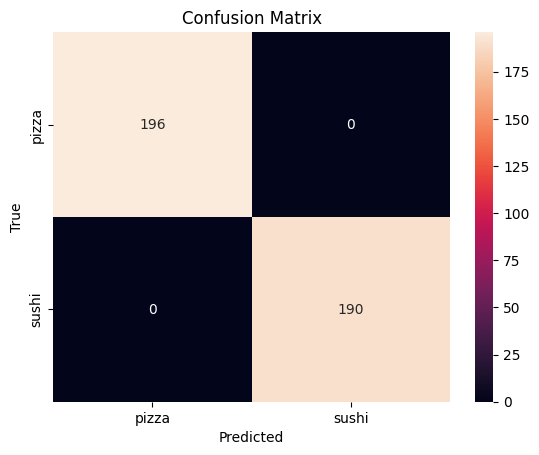

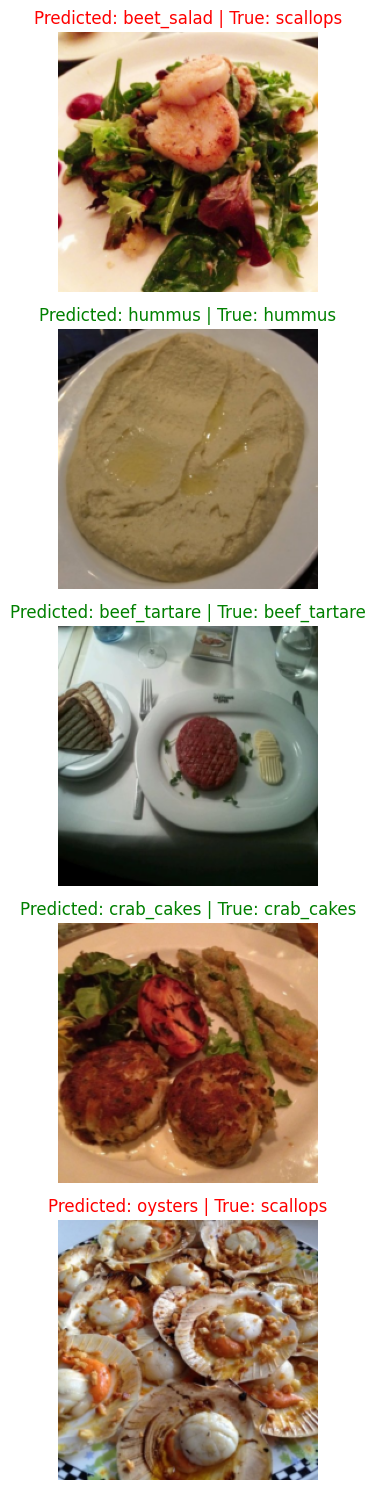

In [ ]:
visualizer = Food101Visualizer(classes)
visualizer.plot_confusion_matrix(labels, preds, selected_classes=['pizza', 'sushi'])
visualizer.plot_sample_predictions(trainer.model, test_loader.dataset, trainer.device)

In [ ]:
trainer = Food101ModelTrainer(train_loader, val_loader, classes, model_name='resnet18', lr=0.001, optimizer_type='adam')
trainer.train(epochs=5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=2.7268, Train Acc=0.3348, Val Loss=2.2090, Val Acc=0.4524
Epoch 2: Train Loss=1.8616, Train Acc=0.5175, Val Loss=1.8482, Val Acc=0.5370
Epoch 3: Train Loss=1.4582, Train Acc=0.6117, Val Loss=2.0488, Val Acc=0.5100
Epoch 4: Train Loss=1.1246, Train Acc=0.6908, Val Loss=1.7331, Val Acc=0.5830
Epoch 5: Train Loss=0.8259, Train Acc=0.7633, Val Loss=1.7863, Val Acc=0.5832


In [ ]:
evaluator = Food101Evaluator(trainer.model, test_loader, classes, trainer.device)
preds, labels = evaluator.evaluate()

Test Accuracy: 0.6234


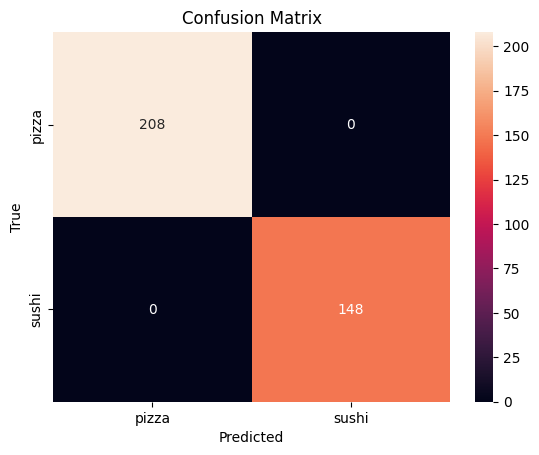

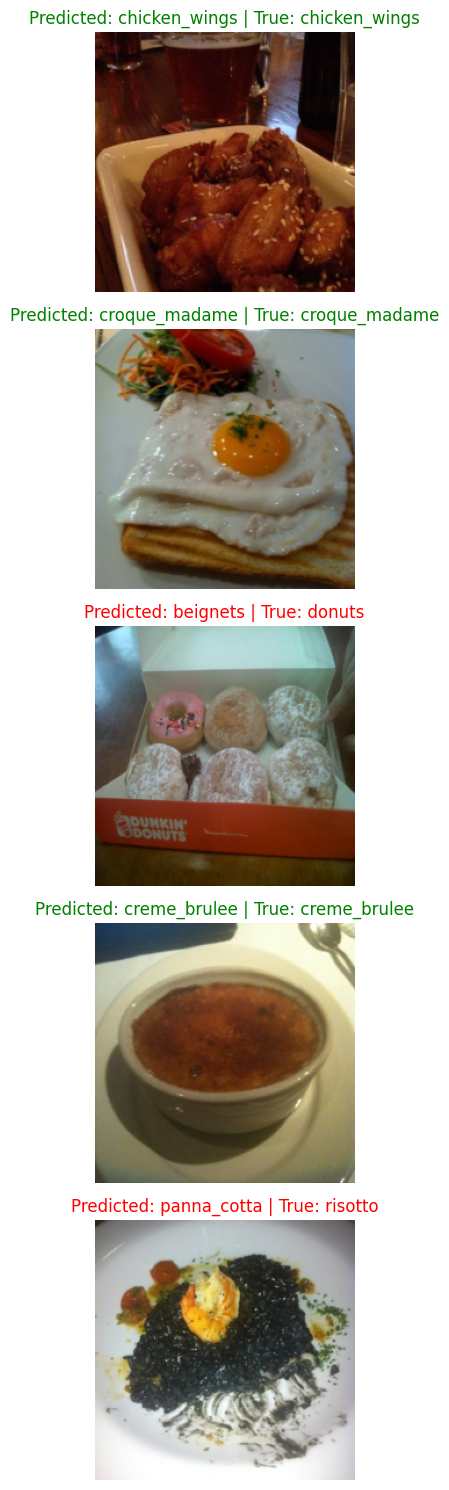

In [ ]:
visualizer = Food101Visualizer(classes)
visualizer.plot_confusion_matrix(labels, preds, selected_classes=['pizza', 'sushi'])
visualizer.plot_sample_predictions(trainer.model, test_loader.dataset, trainer.device)

In [ ]:
# Train & Validation Loss 시각화 (학습 로그를 기반으로 직접 변수 넣어야 함)

# 예시용 (Food101ModelTrainer에서 loss 기록하는 부분이 없으므로 아래와 같이 예시로 넣습니다.)
# 실제 코드에선 Trainer 클래스에서 train_losses, val_losses 리스트를 기록해줘야 합니다.
train_losses = [2.3, 1.8, 1.5, 1.3, 1.2]
val_losses = [2.4, 2.0, 1.7, 1.6, 1.5]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


## 🔗 GitHub 연동 방법 (Colab 기준)

1. **Google Colab에서 GitHub 파일 불러오기**
    ```python
    from google.colab import drive
    drive.mount('/content/drive')
    ```

2. **Git 설치 및 사용자 정보 설정**
    ```bash
    !git config --global user.name "YourName"
    !git config --global user.email "YourEmail@example.com"
    ```

3. **GitHub 레포지토리 클론하기**
    ```bash
    !git clone https://github.com/YourUsername/YourRepository.git
    ```

4. **작업물 GitHub로 push 하기**
    ```bash
    %cd /content/YourRepository
    !git add .
    !git commit -m "Update notebook"
    !git push origin main
    ```

> Personal Access Token (PAT) 을 활용한 인증 필요 (https://github.com/settings/tokens)


In [ ]:
# Train & Validation Loss 시각화 (학습 로그를 기반으로 직접 변수 넣어야 함)

# 예시용 (Food101ModelTrainer에서 loss 기록하는 부분이 없으므로 아래와 같이 예시로 넣습니다.)
# 실제 코드에선 Trainer 클래스에서 train_losses, val_losses 리스트를 기록해줘야 합니다.
train_losses = [2.3, 1.8, 1.5, 1.3, 1.2]
val_losses = [2.4, 2.0, 1.7, 1.6, 1.5]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


## 🔗 GitHub 연동 방법 (Colab 기준)

1. **Google Colab에서 GitHub 파일 불러오기**
    ```python
    from google.colab import drive
    drive.mount('/content/drive')
    ```

2. **Git 설치 및 사용자 정보 설정**
    ```bash
    !git config --global user.name "YourName"
    !git config --global user.email "YourEmail@example.com"
    ```

3. **GitHub 레포지토리 클론하기**
    ```bash
    !git clone https://github.com/YourUsername/YourRepository.git
    ```

4. **작업물 GitHub로 push 하기**
    ```bash
    %cd /content/YourRepository
    !git add .
    !git commit -m "Update notebook"
    !git push origin main
    ```

> Personal Access Token (PAT) 을 활용한 인증 필요 (https://github.com/settings/tokens)


In [ ]:
# Train & Validation Loss 시각화 (Food101 학습 로그 기반 예시)
# 실제 사용시 Trainer에서 train_losses, val_losses 리스트 기록이 필요합니다.

# 임시 예시 값 (수정 필요)
train_losses = [2.3, 1.8, 1.5, 1.3, 1.2]
val_losses = [2.4, 2.0, 1.7, 1.6, 1.5]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


## 🔗 GitHub 연동 방법 (Colab 기준)

1. **Google Colab에서 GitHub 파일 불러오기**
    ```python
    from google.colab import drive
    drive.mount('/content/drive')
    ```

2. **Git 설치 및 사용자 정보 설정**
    ```bash
    !git config --global user.name "YourName"
    !git config --global user.email "YourEmail@example.com"
    ```

3. **GitHub 레포지토리 클론하기**
    ```bash
    !git clone https://github.com/YourUsername/YourRepository.git
    ```

4. **작업물 GitHub로 push 하기**
    ```bash
    %cd /content/YourRepository
    !git add .
    !git commit -m "Update notebook"
    !git push origin main
    ```

> Personal Access Token (PAT)을 이용한 인증 필요 (https://github.com/settings/tokens)


In [ ]:
# Train & Validation Loss 시각화 (Food101 학습 로그 기반 예시)
# 실제 사용시 Trainer에서 train_losses, val_losses 리스트 기록이 필요합니다.

# 임시 예시 값 (수정 필요)
train_losses = [2.3, 1.8, 1.5, 1.3, 1.2]
val_losses = [2.4, 2.0, 1.7, 1.6, 1.5]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


## 🔗 GitHub 연동 방법 (Colab 기준)

1. **Google Colab에서 GitHub 파일 불러오기**
    ```python
    from google.colab import drive
    drive.mount('/content/drive')
    ```

2. **Git 설치 및 사용자 정보 설정**
    ```bash
    !git config --global user.name "YourName"
    !git config --global user.email "YourEmail@example.com"
    ```

3. **GitHub 레포지토리 클론하기**
    ```bash
    !git clone https://github.com/YourUsername/YourRepository.git
    ```

4. **작업물 GitHub로 push 하기**
    ```bash
    %cd /content/YourRepository
    !git add .
    !git commit -m "Update notebook"
    !git push origin main
    ```

> Personal Access Token (PAT)을 이용한 인증 필요 (https://github.com/settings/tokens)
